**Sugarcane Disease Veri Seti**

In [ ]:
# [Hücre 1] - Gerekli kütüphanelerin import edilmesi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, DenseNet121, VGG16, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import pandas as pd

In [ ]:
# [Hücre 2] - Veri setinin hazırlanması
# Veri seti yolları
zip_path = '/content/drive/MyDrive/Sugarcane Disease.zip'
extract_path = '/content/dataset'

# Klasör kontrolü ve zip dosyasının çıkarılması
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Klasör oluşturuldu: {extract_path}")

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Zip dosyası başarıyla çıkarıldı.")
else:
    print("Zip dosyası bulunamadı! Lütfen dosya yolunu kontrol edin.")

data_dir = extract_path

# Veri seti yapısının kontrolü
print("\nMevcut klasörler:")
print(os.listdir(data_dir))

Zip dosyası başarıyla çıkarıldı.

Mevcut klasörler:
['Yellow', 'RedRot', 'Rust', 'Healthy', 'Mosaic']


In [ ]:
# [Hücre 3] - Yardımcı fonksiyonların tanımlanması
def plot_training_history(history, model_name):
    """Eğitim metriklerinin görselleştirilmesi"""
    plt.figure(figsize=(15, 5))

    # Accuracy grafiği
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Loss grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names, model_name):
    """Karmaşıklık matrisinin görselleştirilmesi"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(fpr, tpr, roc_auc, class_names, model_name):
    """ROC eğrilerinin görselleştirilmesi"""
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i],
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [ ]:
# [Hücre 4] - Data Generator'ların oluşturulması
def create_data_generators(data_dir, img_height, img_width, batch_size):
    """Veri yükleyicilerin oluşturulması ve veri setinin bölünmesi"""

    # Train ve validation için generator (data augmentation ile)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.1,  # %10 validation
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        shear_range=0.2,
        zoom_range=0.2
    )

    # Test için generator (sadece rescaling)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Training generator (%75 * 0.9 = %67.5 of total data)
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Validation generator (%75 * 0.1 = %7.5 of total data)
    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    # Test generator (%25 of total data)
    test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator


In [ ]:
# [Hücre 5] - Model oluşturma fonksiyonu
def create_model(base_model_name, num_classes, img_height, img_width):
    """Transfer learning modelinin oluşturulması"""

    # Base model seçimi
    if base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False,
                               input_shape=(img_height, img_width, 3))
    elif base_model_name == 'DenseNet':
        base_model = DenseNet121(weights='imagenet', include_top=False,
                                input_shape=(img_height, img_width, 3))
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False,
                          input_shape=(img_height, img_width, 3))
    elif base_model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False,
                          input_shape=(img_height, img_width, 3))
    else:
        raise ValueError(f"Bilinmeyen model adı: {base_model_name}")

    # Yeni katmanların eklenmesi
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Model oluşturma
    model = Model(inputs=base_model.input, outputs=predictions)

    # Base model katmanlarını dondurma
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [ ]:
# [Hücre 6] - Model değerlendirme fonksiyonu
def evaluate_model(model, test_generator, class_names, model_name):
    """Modelin kapsamlı değerlendirilmesi"""

    # Tahminlerin alınması
    y_pred_proba = model.predict(test_generator)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_generator.classes

    # Temel metriklerin hesaplanması
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=class_names)
    matthews_coef = matthews_corrcoef(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)

    # ROC eğrileri için hesaplamalar
    n_classes = len(class_names)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(
            tf.keras.utils.to_categorical(y_true)[:, i],
            y_pred_proba[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Görselleştirmeler
    plot_confusion_matrix(conf_matrix, class_names, model_name)
    plot_roc_curves(fpr, tpr, roc_auc, class_names, model_name)

    # Sonuçların yazdırılması
    print(f"\n{'-'*20} {model_name} Değerlendirme Sonuçları {'-'*20}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    print(f"\nMatthews Correlation Coefficient: {matthews_coef:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Mean ROC AUC: {np.mean(list(roc_auc.values())):.4f}")

    return {
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'matthews_coef': matthews_coef,
        'balanced_accuracy': balanced_acc,
        'roc_auc': roc_auc,
        'test_accuracy': model.evaluate(test_generator)[1]
    }

In [ ]:
# [Hücre 7] - Ana konfigürasyon
# Model parametreleri
img_height = 224
img_width = 224
batch_size = 32
epochs = 50

# Data generator'ların oluşturulması
train_generator, validation_generator, test_generator = create_data_generators(
    data_dir, img_height, img_width, batch_size
)

# Sınıf bilgilerinin alınması
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

# Veri seti boyutlarının yazdırılması
print(f"Toplam sınıf sayısı: {num_classes}")
print(f"Sınıf isimleri: {class_names}")
print(f"\nEğitim seti boyutu: {train_generator.samples}")
print(f"Validation seti boyutu: {validation_generator.samples}")
print(f"Test seti boyutu: {test_generator.samples}")

Found 2271 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 2521 images belonging to 5 classes.
Toplam sınıf sayısı: 5
Sınıf isimleri: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

Eğitim seti boyutu: 2271
Validation seti boyutu: 250
Test seti boyutu: 2521



============================== InceptionV3 Eğitimi ==============================
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.3582 - loss: 2.6765
Epoch 1: val_loss improved from inf to 1.13123, saving model to best_InceptionV3.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 884ms/step - accuracy: 0.3598 - loss: 2.6632 - val_accuracy: 0.5446 - val_loss: 1.1312
Epoch 2/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.6562 - loss: 1.0050

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.13123 to 0.93758, saving model to best_InceptionV3.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.6562 - loss: 1.0050 - val_accuracy: 0.6154 - val_loss: 0.9376
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.6424 - loss: 0.9001
Epoch 3: val_loss did not improve from 0.93758
70/70 ━━━━━━━━━━━━━━━━━━━━ 50s 623ms/step - accuracy: 0.6426 - loss: 0.8999 - val_accuracy: 0.5536 - val_loss: 1.0355
Epoch 4/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6562 - loss: 0.8783
Epoch 4: val_loss did not improve from 0.93758
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.8783 - val_accuracy: 0.5769 - val_loss: 1.0247
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.6764 - loss: 0.8333
Epoch 5: val_loss did not improve from 0.93758
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 621ms/step - accuracy: 0.6765 - loss: 0.8332 - val_accuracy: 0.6295 - val_loss: 0.9401
Epoch 6/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 6s 9

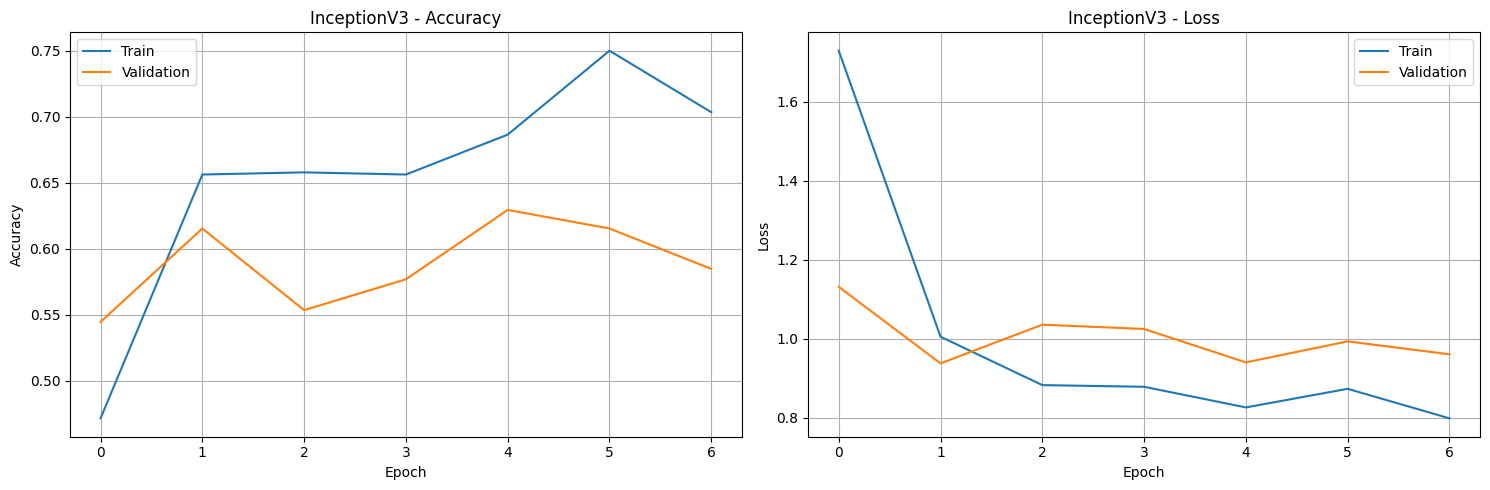

79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 365ms/step


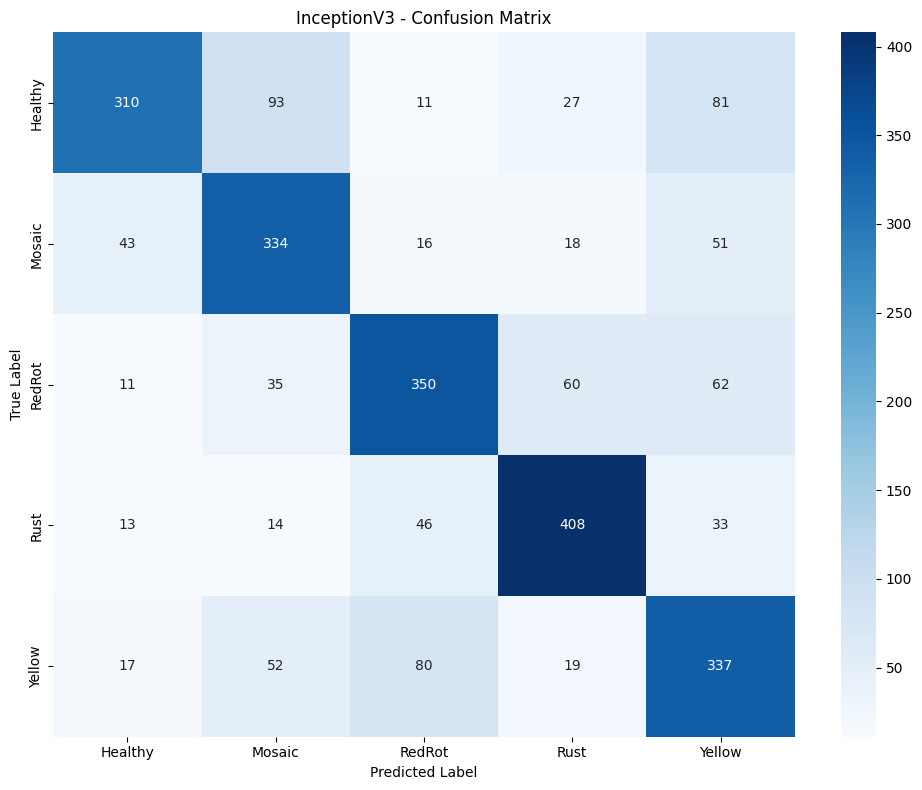

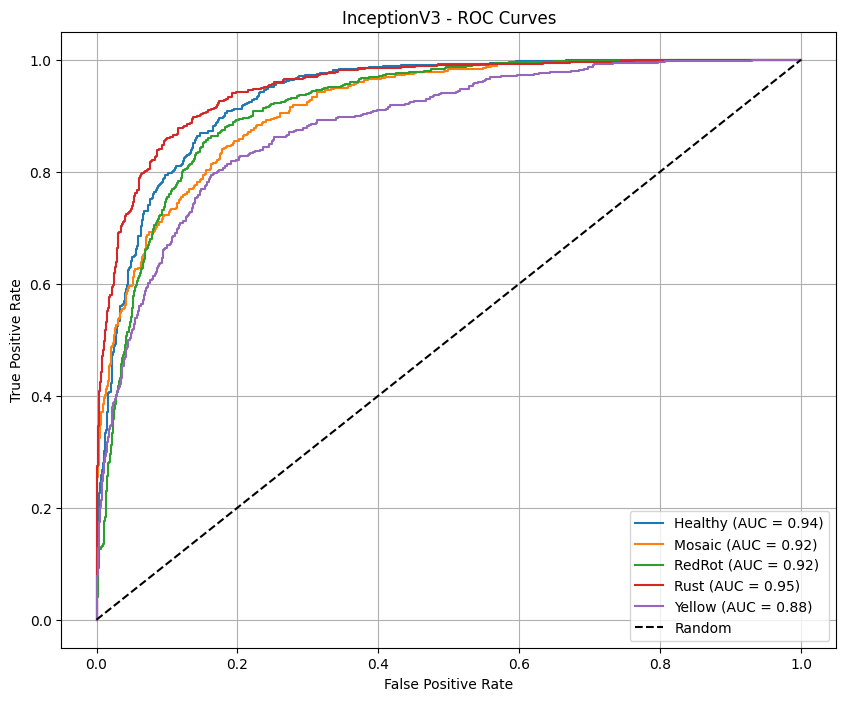


-------------------- InceptionV3 Değerlendirme Sonuçları --------------------

Confusion Matrix:
[[310  93  11  27  81]
 [ 43 334  16  18  51]
 [ 11  35 350  60  62]
 [ 13  14  46 408  33]
 [ 17  52  80  19 337]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.79      0.59      0.68       522
      Mosaic       0.63      0.72      0.67       462
      RedRot       0.70      0.68      0.69       518
        Rust       0.77      0.79      0.78       514
      Yellow       0.60      0.67      0.63       505

    accuracy                           0.69      2521
   macro avg       0.70      0.69      0.69      2521
weighted avg       0.70      0.69      0.69      2521


Matthews Correlation Coefficient: 0.6140
Balanced Accuracy: 0.6907
Mean ROC AUC: 0.9207
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 313ms/step - accuracy: 0.6611 - loss: 0.8787

============================== DenseNet Eğitimi ==============================
29084464/29084464 ━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.00073
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.5000 - loss: 1.0105 - val_accuracy: 0.6538 - val_loss: 1.0473
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7384 - loss: 0.7174
Epoch 3: val_loss improved from 1.00073 to 0.80438, saving model to best_DenseNet.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 95s 641ms/step - accuracy: 0.7385 - loss: 0.7169 - val_accuracy: 0.7009 - val_loss: 0.8044
Epoch 4/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7500 - loss: 0.7770
Epoch 4: val_loss did not improve from 0.80438
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.7770 - val_accuracy: 0.5000 - val_loss: 0.9319
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8016 - loss: 0.5471
Epoch 5: val_loss improved from 0.80438 to 0.72757, saving model to best_DenseNet.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 629ms/step - accuracy: 0.8015 - loss: 0.5473 - val_accuracy: 0.7366 - val_loss: 0.7276
Ep

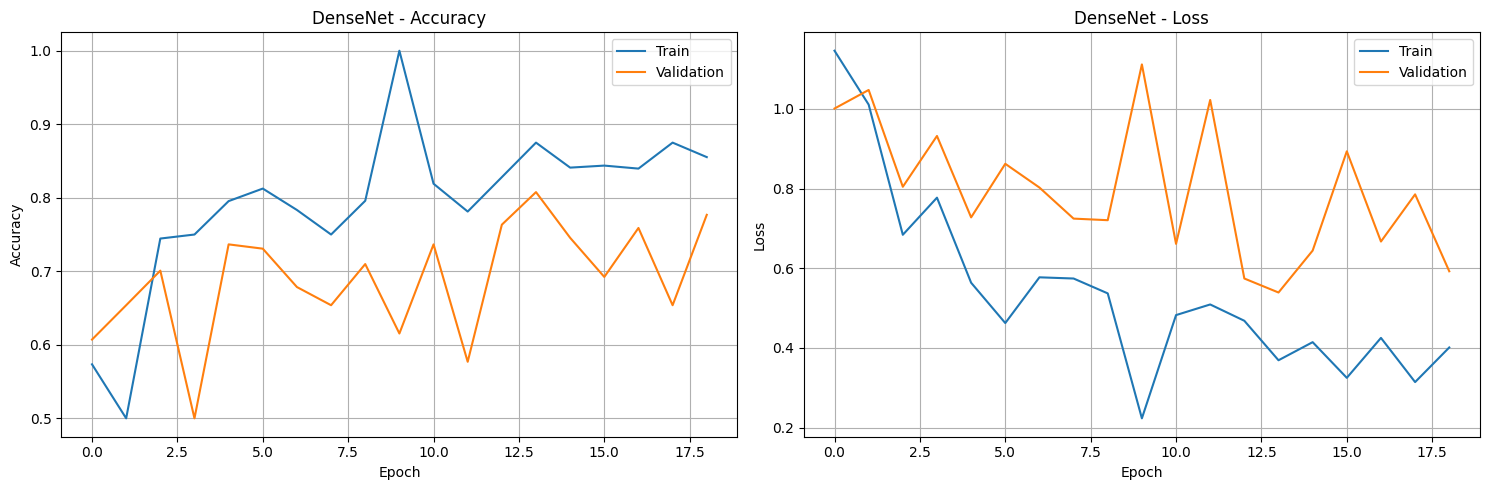

79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 427ms/step


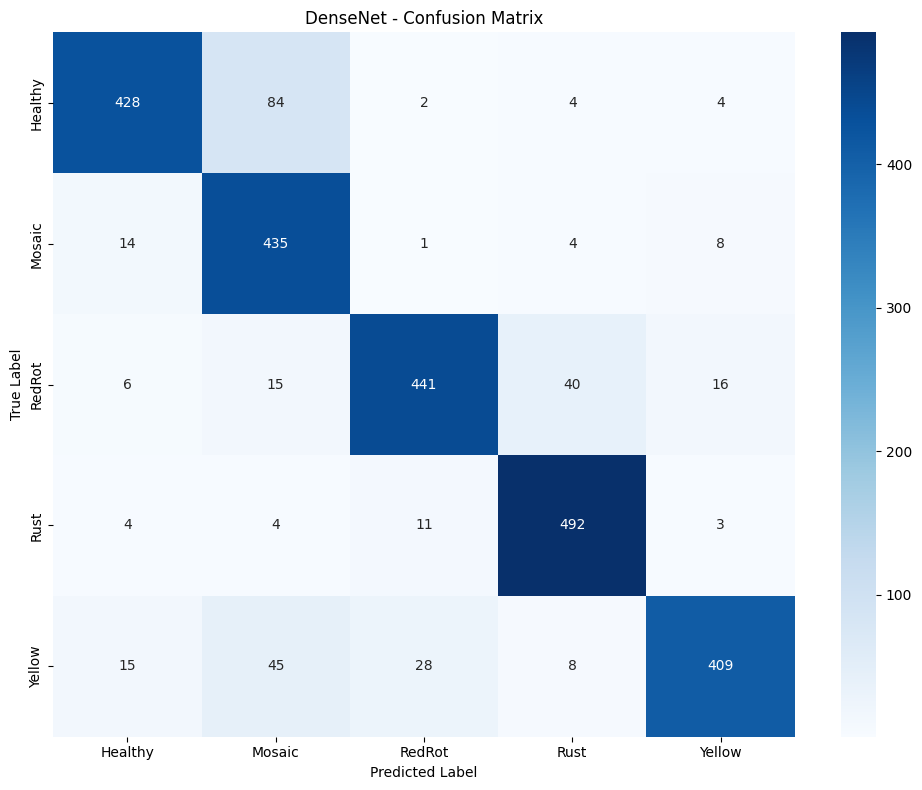

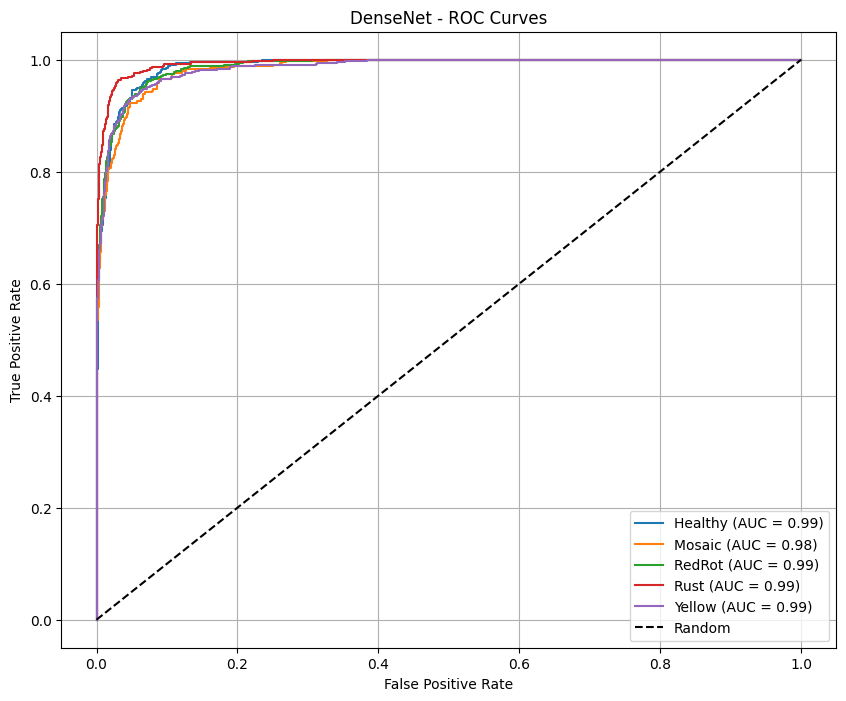


-------------------- DenseNet Değerlendirme Sonuçları --------------------

Confusion Matrix:
[[428  84   2   4   4]
 [ 14 435   1   4   8]
 [  6  15 441  40  16]
 [  4   4  11 492   3]
 [ 15  45  28   8 409]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.92      0.82      0.87       522
      Mosaic       0.75      0.94      0.83       462
      RedRot       0.91      0.85      0.88       518
        Rust       0.90      0.96      0.93       514
      Yellow       0.93      0.81      0.87       505

    accuracy                           0.87      2521
   macro avg       0.88      0.88      0.87      2521
weighted avg       0.88      0.87      0.88      2521


Matthews Correlation Coefficient: 0.8455
Balanced Accuracy: 0.8760
Mean ROC AUC: 0.9882
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.8717 - loss: 0.3189

============================== VGG16 Eğitimi ==============================
58889256/58889256 ━━━━━━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.49808 to 1.29584, saving model to best_VGG16.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.5000 - loss: 1.1466 - val_accuracy: 0.4231 - val_loss: 1.2958
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.5231 - loss: 1.2149
Epoch 3: val_loss did not improve from 1.29584
70/70 ━━━━━━━━━━━━━━━━━━━━ 53s 672ms/step - accuracy: 0.5232 - loss: 1.2148 - val_accuracy: 0.3750 - val_loss: 1.3475
Epoch 4/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.5625 - loss: 1.0942
Epoch 4: val_loss did not improve from 1.29584
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5625 - loss: 1.0942 - val_accuracy: 0.1923 - val_loss: 1.6984
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5412 - loss: 1.1480
Epoch 5: val_loss did not improve from 1.29584
70/70 ━━━━━━━━━━━━━━━━━━━━ 52s 687ms/step - accuracy: 0.5415 - loss: 1.1472 - val_accuracy: 0.4018 - val_loss: 1.3987
Epoch 6/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 10s 147m

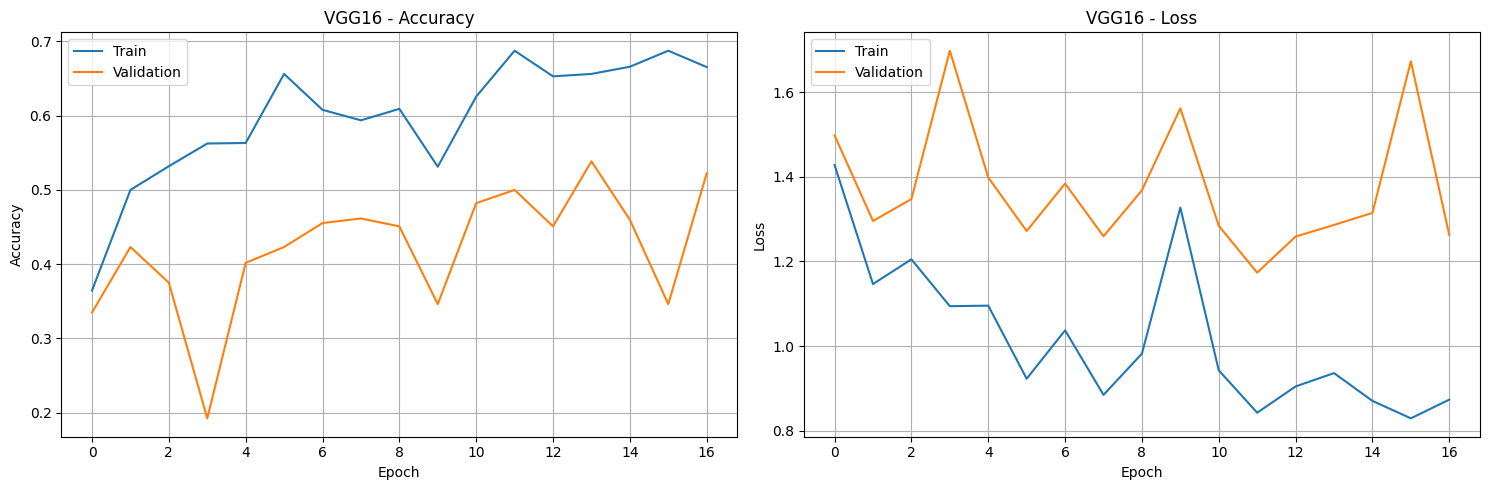

79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 436ms/step


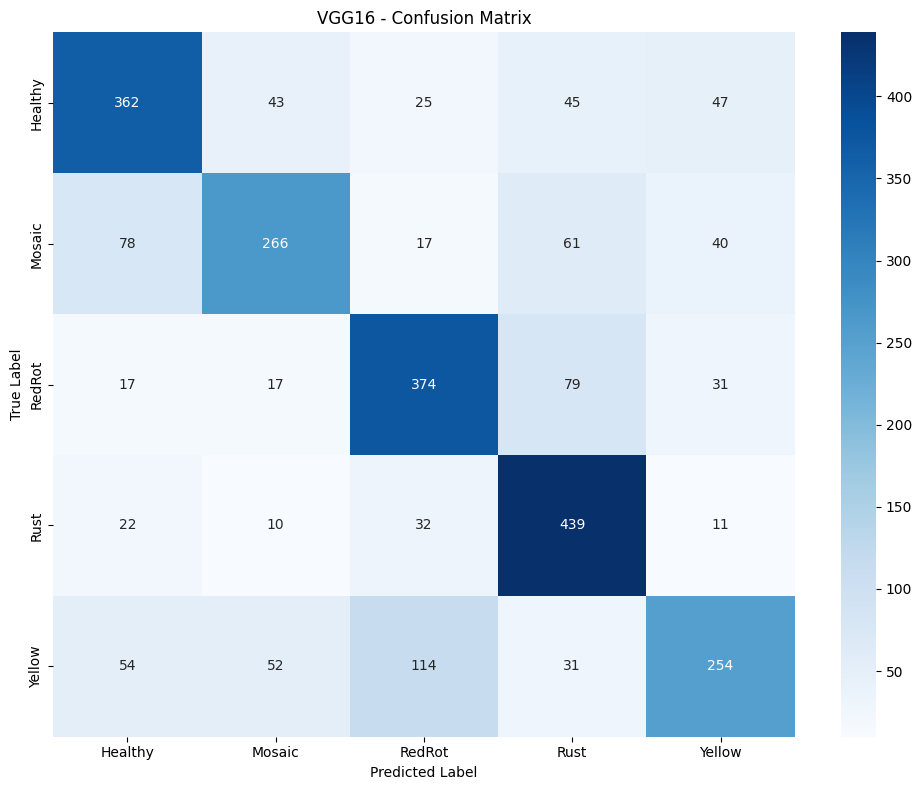

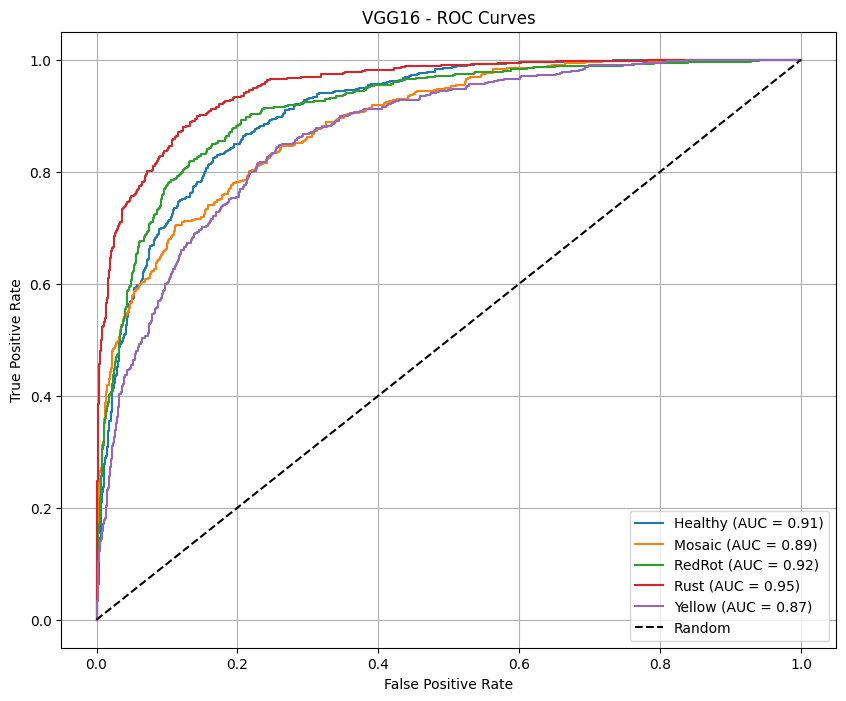


-------------------- VGG16 Değerlendirme Sonuçları --------------------

Confusion Matrix:
[[362  43  25  45  47]
 [ 78 266  17  61  40]
 [ 17  17 374  79  31]
 [ 22  10  32 439  11]
 [ 54  52 114  31 254]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.68      0.69      0.69       522
      Mosaic       0.69      0.58      0.63       462
      RedRot       0.67      0.72      0.69       518
        Rust       0.67      0.85      0.75       514
      Yellow       0.66      0.50      0.57       505

    accuracy                           0.67      2521
   macro avg       0.67      0.67      0.67      2521
weighted avg       0.67      0.67      0.67      2521


Matthews Correlation Coefficient: 0.5923
Balanced Accuracy: 0.6697
Mean ROC AUC: 0.9065
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.6845 - loss: 0.8819

============================== VGG19 Eğitimi ==============================
80134624/80134624 ━━━━━━━━━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.44974 to 1.41593, saving model to best_VGG19.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5938 - loss: 1.1028 - val_accuracy: 0.3462 - val_loss: 1.4159
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.4613 - loss: 1.2715
Epoch 3: val_loss did not improve from 1.41593
70/70 ━━━━━━━━━━━━━━━━━━━━ 71s 705ms/step - accuracy: 0.4617 - loss: 1.2708 - val_accuracy: 0.4330 - val_loss: 1.4447
Epoch 4/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.3125 - loss: 1.4157
Epoch 4: val_loss improved from 1.41593 to 1.33464, saving model to best_VGG19.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3125 - loss: 1.4157 - val_accuracy: 0.5385 - val_loss: 1.3346
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.5555 - loss: 1.1319
Epoch 5: val_loss improved from 1.33464 to 1.30101, saving model to best_VGG19.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 747ms/step - accuracy: 0.5554 - loss: 1.1319 - val_accura

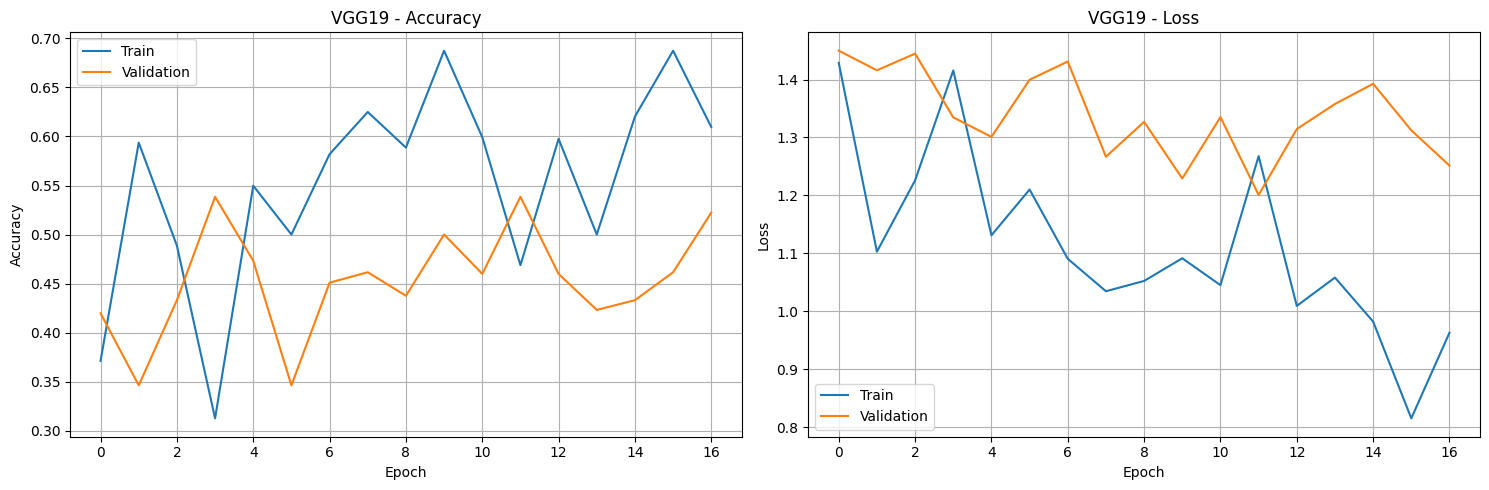

79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 277ms/step


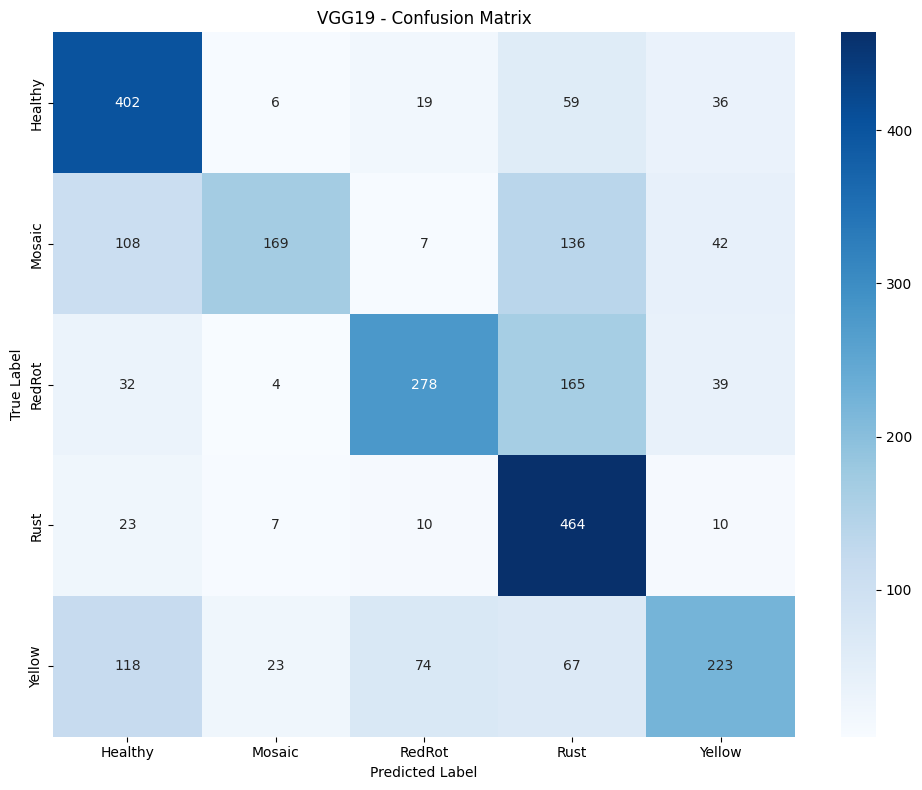

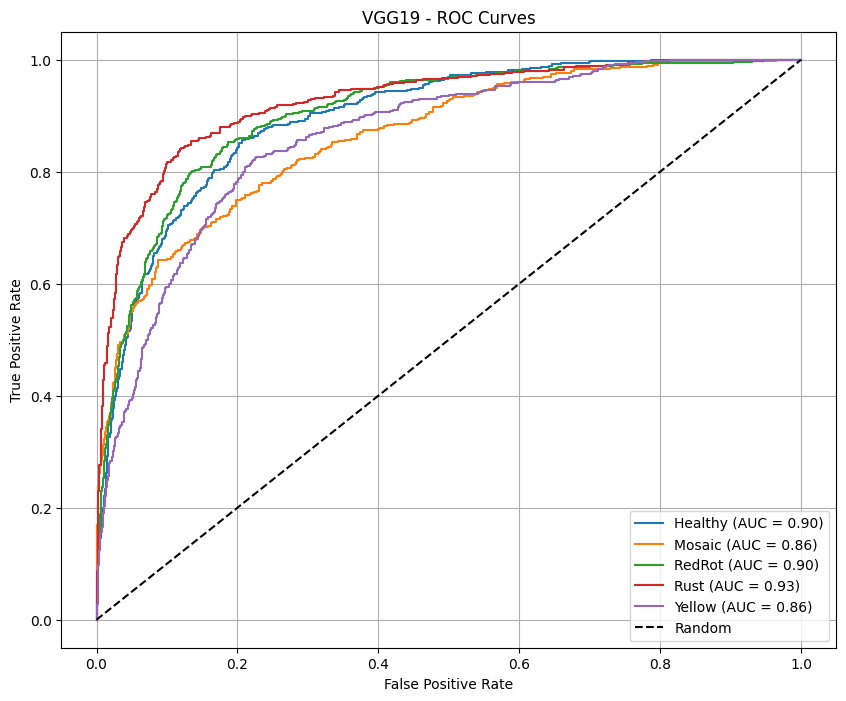


-------------------- VGG19 Değerlendirme Sonuçları --------------------

Confusion Matrix:
[[402   6  19  59  36]
 [108 169   7 136  42]
 [ 32   4 278 165  39]
 [ 23   7  10 464  10]
 [118  23  74  67 223]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.59      0.77      0.67       522
      Mosaic       0.81      0.37      0.50       462
      RedRot       0.72      0.54      0.61       518
        Rust       0.52      0.90      0.66       514
      Yellow       0.64      0.44      0.52       505

    accuracy                           0.61      2521
   macro avg       0.65      0.60      0.59      2521
weighted avg       0.65      0.61      0.60      2521


Matthews Correlation Coefficient: 0.5243
Balanced Accuracy: 0.6034
Mean ROC AUC: 0.8905
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 345ms/step - accuracy: 0.6483 - loss: 0.9930


In [ ]:
# [Hücre 8] - Model eğitimi ve değerlendirmesi
# Eğitilecek modeller
models_to_train = ['InceptionV3', 'DenseNet', 'VGG16', 'VGG19']
results = {}

for model_name in models_to_train:
    print(f"\n{'='*30} {model_name} Eğitimi {'='*30}")

    # Model oluşturma ve derleme
    model = create_model(model_name, num_classes, img_height, img_width)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        mode='min',
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        f'best_{model_name}.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Model eğitimi
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Eğitim geçmişinin görselleştirilmesi
    plot_training_history(history, model_name)

    # Model değerlendirmesi
    results[model_name] = evaluate_model(model, test_generator, class_names, model_name)


============================== InceptionV3 Eğitimi ==============================
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 71s 788ms/step - accuracy: 0.4046 - loss: 2.4031 - val_accuracy: 0.5580 - val_loss: 1.1094
Epoch 2/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.5938 - loss: 0.9990

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5938 - loss: 0.9990 - val_accuracy: 0.7308 - val_loss: 0.9108
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 66s 652ms/step - accuracy: 0.6407 - loss: 0.8969 - val_accuracy: 0.5982 - val_loss: 1.0276
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.7434 - val_accuracy: 0.5385 - val_loss: 1.2093
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 638ms/step - accuracy: 0.6776 - loss: 0.8140 - val_accuracy: 0.6429 - val_loss: 0.9001
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.6875 - loss: 1.0673 - val_accuracy: 0.6538 - val_loss: 0.8577
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 628ms/step - accuracy: 0.6849 - loss: 0.8087 - val_accuracy: 0.6429 - val_loss: 0.9237
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.6822 - val_accuracy: 0.7692 - val_loss: 0.6548
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 627ms/step - accuracy: 0.7015 - loss: 0.7585 - val_accuracy: 0.5982 - val_lo

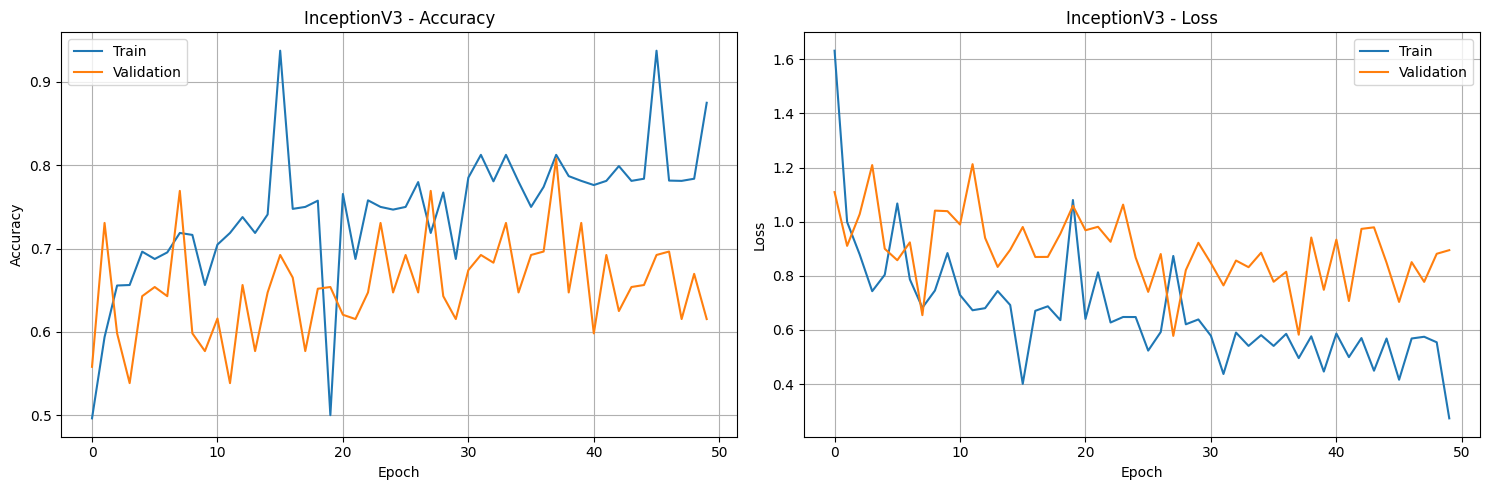

79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step


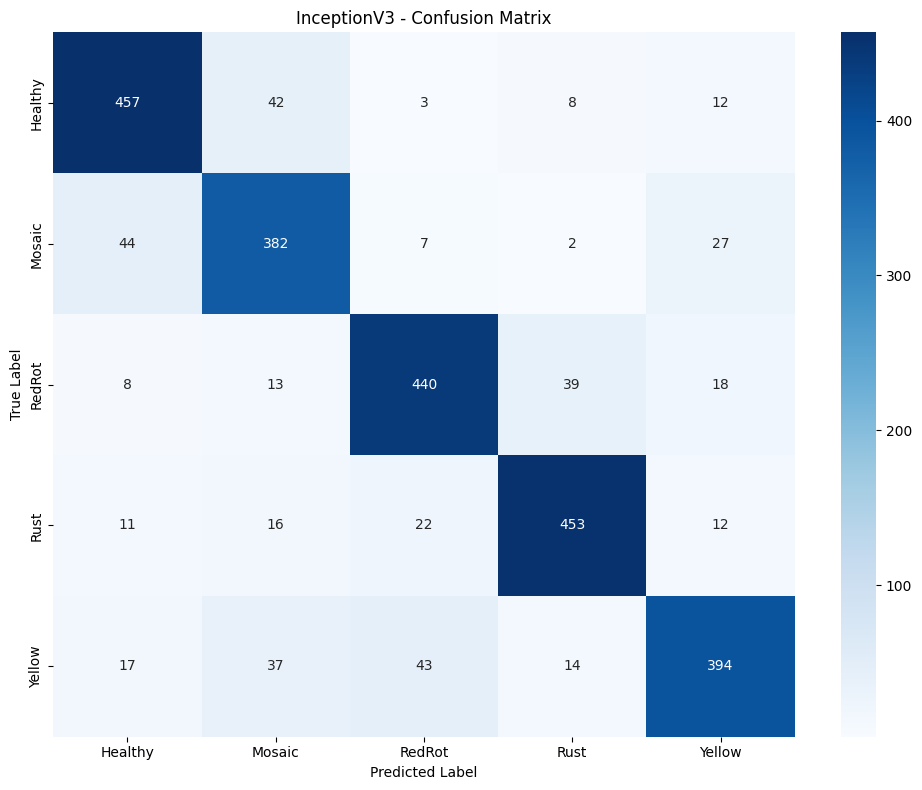

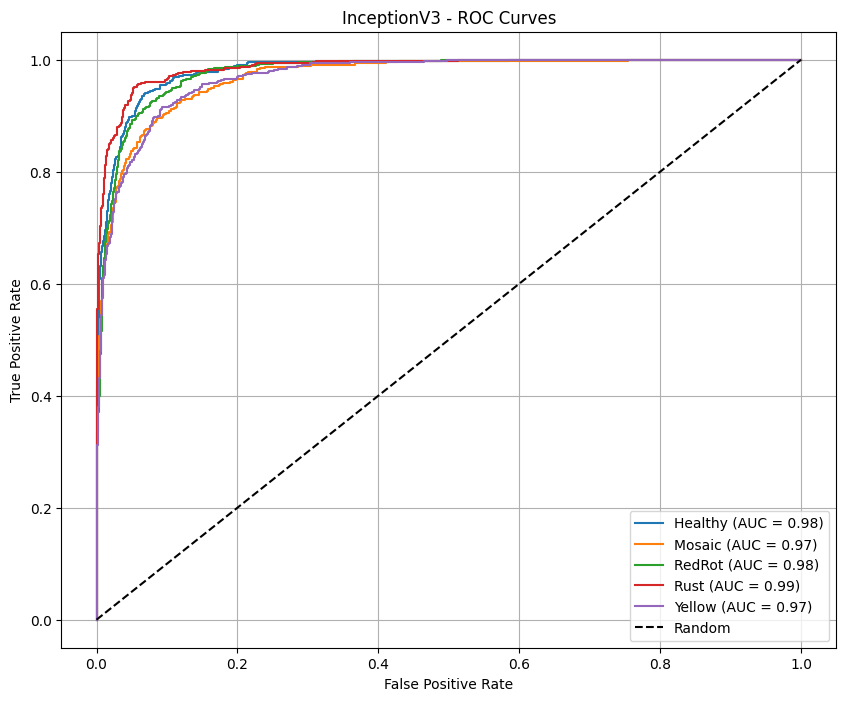


-------------------- InceptionV3 Değerlendirme Sonuçları --------------------

Confusion Matrix:
[[457  42   3   8  12]
 [ 44 382   7   2  27]
 [  8  13 440  39  18]
 [ 11  16  22 453  12]
 [ 17  37  43  14 394]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.85      0.88      0.86       522
      Mosaic       0.78      0.83      0.80       462
      RedRot       0.85      0.85      0.85       518
        Rust       0.88      0.88      0.88       514
      Yellow       0.85      0.78      0.81       505

    accuracy                           0.84      2521
   macro avg       0.84      0.84      0.84      2521
weighted avg       0.84      0.84      0.84      2521


Matthews Correlation Coefficient: 0.8043
Balanced Accuracy: 0.8427
Mean ROC AUC: 0.9772
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - accuracy: 0.8575 - loss: 0.3869

============================== DenseNet Eğitimi ==============================
Epoch 1/50
70/70 ━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6875 - loss: 0.8910 - val_accuracy: 0.6538 - val_loss: 0.8454
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 54s 673ms/step - accuracy: 0.7701 - loss: 0.6744 - val_accuracy: 0.6920 - val_loss: 0.8259
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7812 - loss: 0.4824 - val_accuracy: 0.6923 - val_loss: 0.8078
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 54s 702ms/step - accuracy: 0.7627 - loss: 0.6401 - val_accuracy: 0.6830 - val_loss: 0.7976
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.4773 - val_accuracy: 0.6923 - val_loss: 0.8574
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 51s 671ms/step - accuracy: 0.7802 - loss: 0.5709 - val_accuracy: 0.7277 - val_loss: 0.5994
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.5448 - val_accuracy: 0.6923 - val_loss: 0.6321
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 52s 688ms/step - accuracy: 0.8113 - loss: 0.5193 - val_accuracy: 0.6830 - val_lo

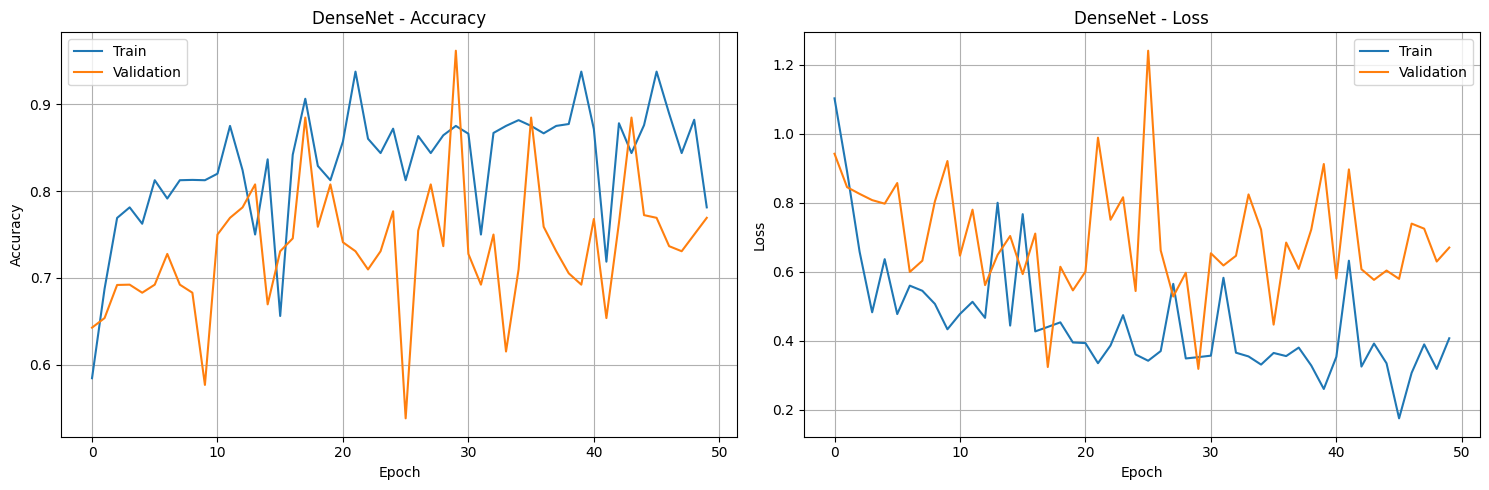

79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 373ms/step


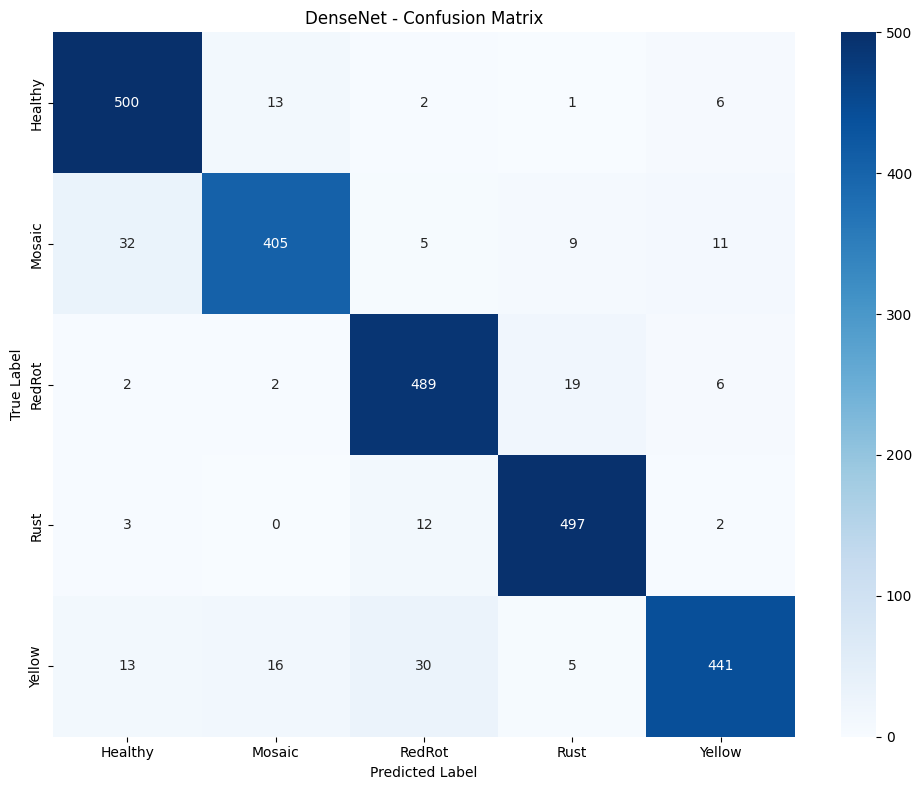

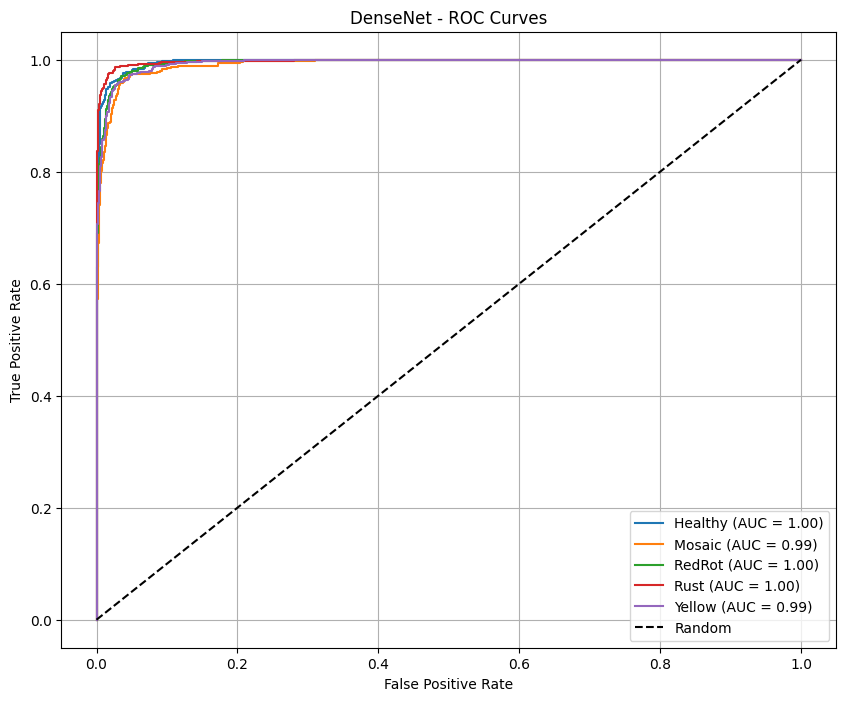


-------------------- DenseNet Değerlendirme Sonuçları --------------------

Confusion Matrix:
[[500  13   2   1   6]
 [ 32 405   5   9  11]
 [  2   2 489  19   6]
 [  3   0  12 497   2]
 [ 13  16  30   5 441]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      0.96      0.93       522
      Mosaic       0.93      0.88      0.90       462
      RedRot       0.91      0.94      0.93       518
        Rust       0.94      0.97      0.95       514
      Yellow       0.95      0.87      0.91       505

    accuracy                           0.93      2521
   macro avg       0.93      0.92      0.92      2521
weighted avg       0.93      0.93      0.92      2521


Matthews Correlation Coefficient: 0.9065
Balanced Accuracy: 0.9237
Mean ROC AUC: 0.9950
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.9335 - loss: 0.1854

============================== VGG16 Eğitimi ==============================
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5625 - loss: 1.2660 - val_accuracy: 0.5385 - val_loss: 1.3634
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 78s 673ms/step - accuracy: 0.4783 - loss: 1.2449 - val_accuracy: 0.3348 - val_loss: 1.4887
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5000 - loss: 1.2365 - val_accuracy: 0.5000 - val_loss: 1.1367
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 643ms/step - accuracy: 0.5467 - loss: 1.1289 - val_accuracy: 0.4062 - val_loss: 1.3315
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 - loss: 0.9084 - val_accuracy: 0.3846 - val_loss: 1.2038
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 85s 656ms/step - accuracy: 0.6032 - loss: 1.0144 - val_accuracy: 0.4152 - val_loss: 1.3279
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5000 - loss: 1.0522 - val_accuracy: 0.4231 - val_loss: 1.4448
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 685ms/step - accuracy: 0.6286 - loss: 0.9979 - val_accuracy: 0.4598 - val_lo

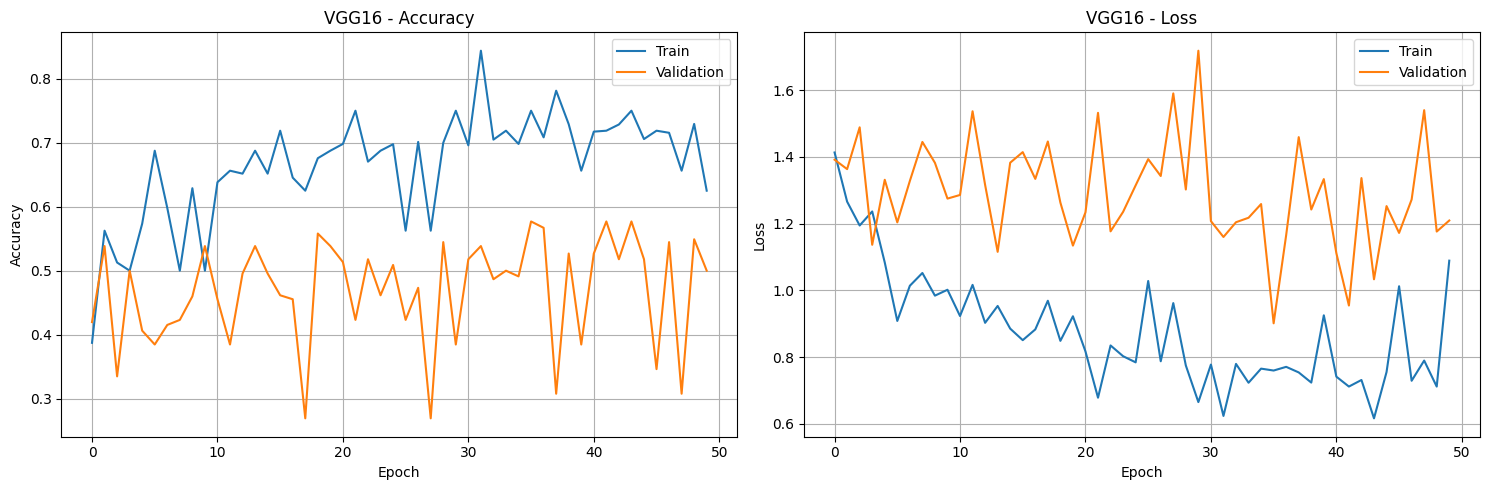

79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step


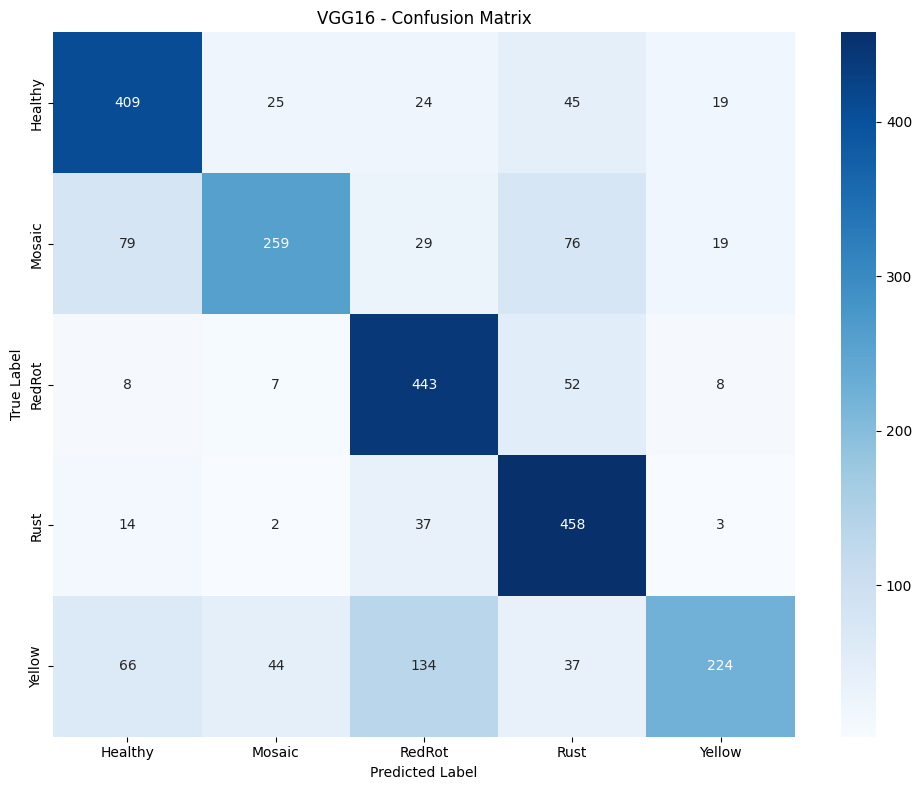

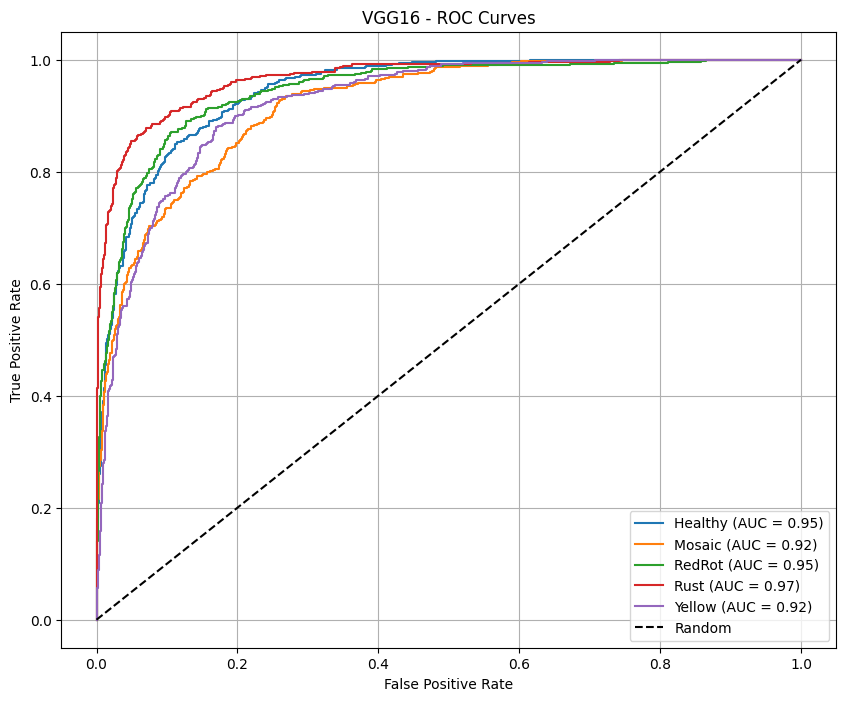


-------------------- VGG16 Değerlendirme Sonuçları --------------------

Confusion Matrix:
[[409  25  24  45  19]
 [ 79 259  29  76  19]
 [  8   7 443  52   8]
 [ 14   2  37 458   3]
 [ 66  44 134  37 224]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.71      0.78      0.74       522
      Mosaic       0.77      0.56      0.65       462
      RedRot       0.66      0.86      0.75       518
        Rust       0.69      0.89      0.77       514
      Yellow       0.82      0.44      0.58       505

    accuracy                           0.71      2521
   macro avg       0.73      0.71      0.70      2521
weighted avg       0.73      0.71      0.70      2521


Matthews Correlation Coefficient: 0.6458
Balanced Accuracy: 0.7068
Mean ROC AUC: 0.9404
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 300ms/step - accuracy: 0.7476 - loss: 0.6981

============================== VGG19 Eğitimi ==============================
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6250 - loss: 1.1439 - val_accuracy: 0.5000 - val_loss: 1.2367
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 73s 649ms/step - accuracy: 0.4733 - loss: 1.2546 - val_accuracy: 0.4464 - val_loss: 1.3762
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4375 - loss: 1.2053 - val_accuracy: 0.3077 - val_loss: 1.2861
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 666ms/step - accuracy: 0.5123 - loss: 1.2150 - val_accuracy: 0.4643 - val_loss: 1.3649
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4688 - loss: 1.1048 - val_accuracy: 0.3846 - val_loss: 1.4531
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 656ms/step - accuracy: 0.5753 - loss: 1.1083 - val_accuracy: 0.4732 - val_loss: 1.3552
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6250 - loss: 1.0309 - val_accuracy: 0.5000 - val_loss: 1.2803
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 661ms/step - accuracy: 0.5590 - loss: 1.0873 - val_accuracy: 0.4554 - val_l

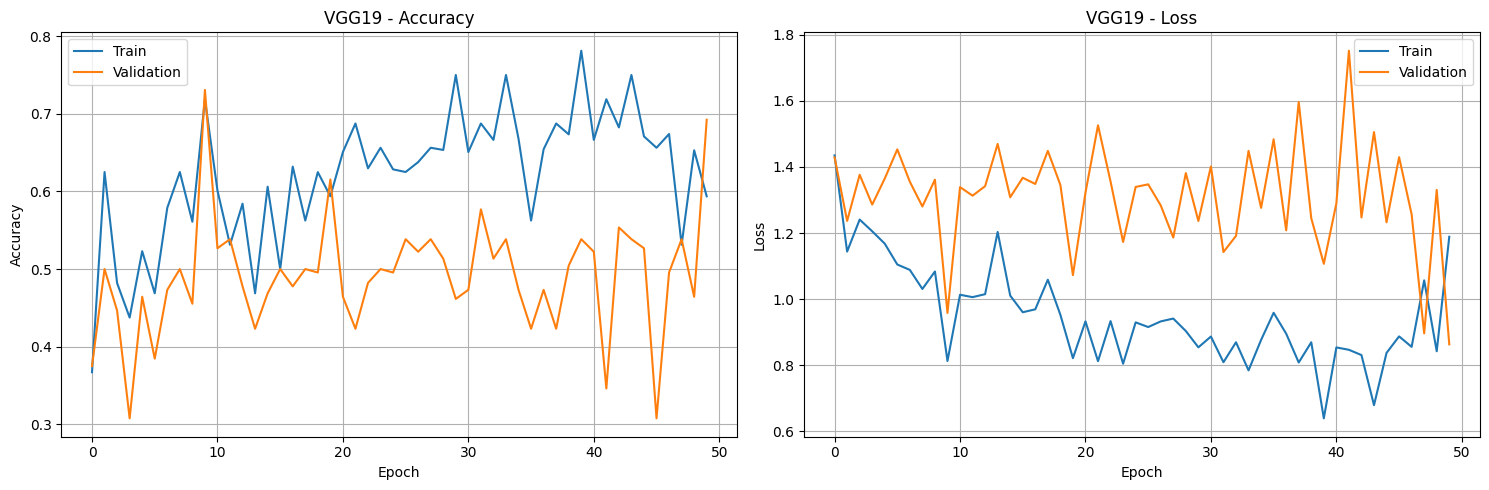

79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step


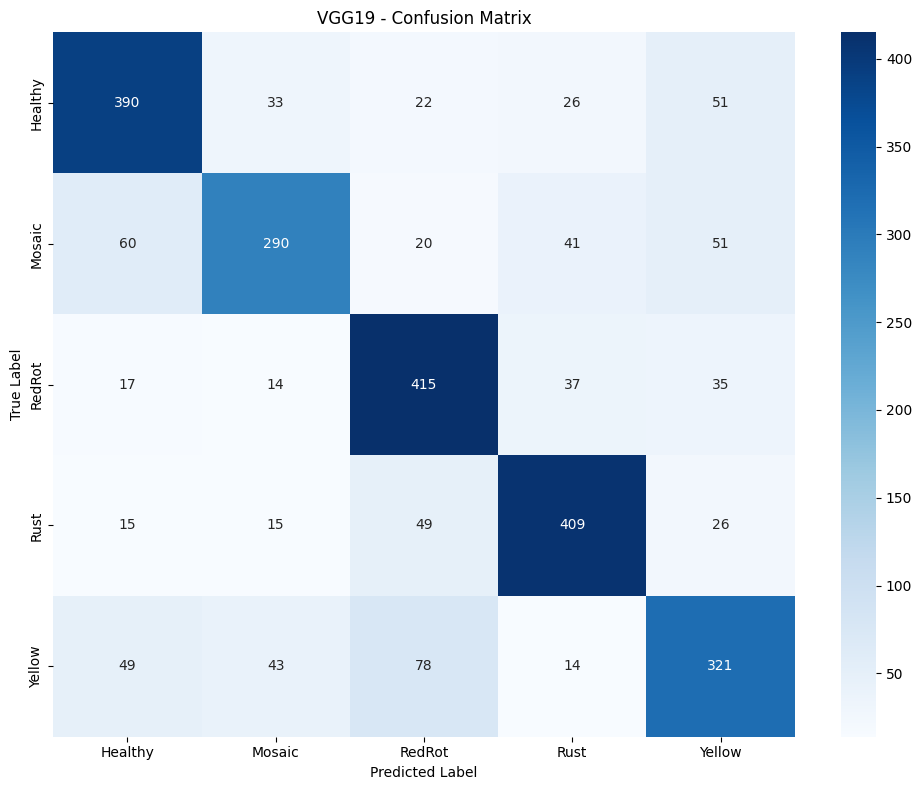

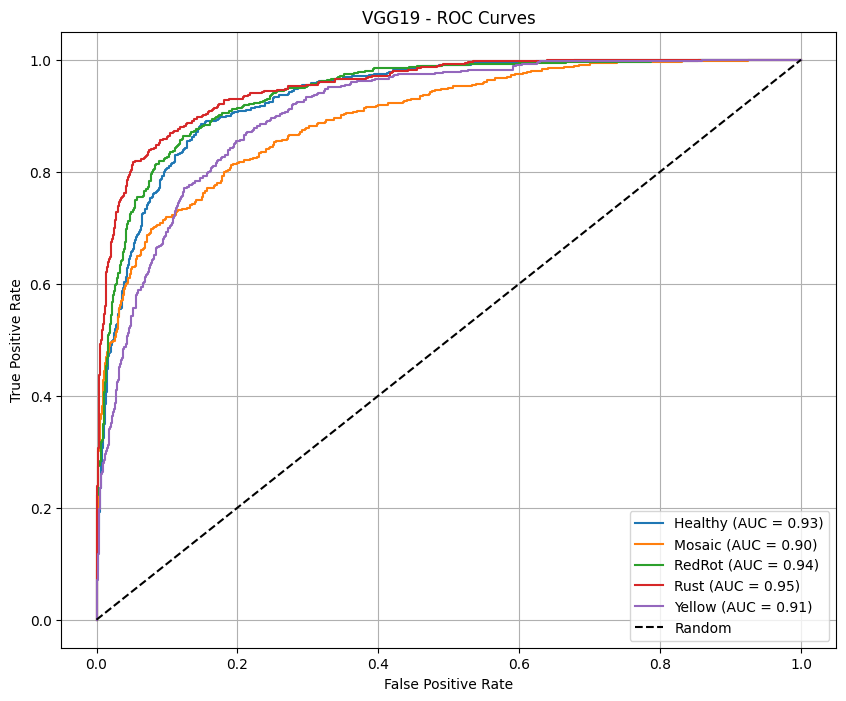


-------------------- VGG19 Değerlendirme Sonuçları --------------------

Confusion Matrix:
[[390  33  22  26  51]
 [ 60 290  20  41  51]
 [ 17  14 415  37  35]
 [ 15  15  49 409  26]
 [ 49  43  78  14 321]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.73      0.75      0.74       522
      Mosaic       0.73      0.63      0.68       462
      RedRot       0.71      0.80      0.75       518
        Rust       0.78      0.80      0.79       514
      Yellow       0.66      0.64      0.65       505

    accuracy                           0.72      2521
   macro avg       0.72      0.72      0.72      2521
weighted avg       0.72      0.72      0.72      2521


Matthews Correlation Coefficient: 0.6551
Balanced Accuracy: 0.7215
Mean ROC AUC: 0.9264
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - accuracy: 0.7270 - loss: 0.7879


In [ ]:
# [Hücre 8.5] Early Stop olmadan - Model eğitimi ve değerlendirmesi
# Eğitilecek modeller
models_to_train = ['InceptionV3', 'DenseNet', 'VGG16', 'VGG19']
results = {}

for model_name in models_to_train:
    print(f"\n{'='*30} {model_name} Eğitimi {'='*30}")

    # Model oluşturma ve derleme
    model = create_model(model_name, num_classes, img_height, img_width)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model_checkpoint = ModelCheckpoint(
        f'bestNew_{model_name}.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Model eğitimi
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=epochs,
        verbose=1
    )

    # Eğitim geçmişinin görselleştirilmesi
    plot_training_history(history, model_name)

    # Model değerlendirmesi
    results[model_name] = evaluate_model(model, test_generator, class_names, model_name)

In [ ]:
# [Hücre 9] - Sonuçların karşılaştırılması
# Karşılaştırma tablosunun oluşturulması
comparison_data = []
for model_name in results:
    comparison_data.append({
        'Model': model_name,
        'Test Accuracy': results[model_name]['test_accuracy'],
        'Balanced Accuracy': results[model_name]['balanced_accuracy'],
        'Matthews Correlation': results[model_name]['matthews_coef'],
        'Mean ROC AUC': np.mean(list(results[model_name]['roc_auc'].values()))
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\nModel Karşılaştırma Sonuçları:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# En iyi performans gösteren modelin belirlenmesi
best_model = comparison_df.loc[comparison_df['Test Accuracy'].idxmax()]
print(f"\nEn iyi performans gösteren model: {best_model['Model']}")


Model Karşılaştırma Sonuçları:
      Model  Test Accuracy  Balanced Accuracy  Matthews Correlation  Mean ROC AUC
InceptionV3         0.8433             0.8427                0.8043        0.9772
   DenseNet         0.9250             0.9237                0.9065        0.9950
      VGG16         0.7112             0.7068                0.6458        0.9404
      VGG19         0.7239             0.7215                0.6551        0.9264

En iyi performans gösteren model: DenseNet
